In [1]:
%matplotlib inline

In [20]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import unicodedata
import string
import torch.nn as nn
import torch

In [21]:
def findFiles(path): return glob.glob(path)

In [22]:
print(findFiles('data/names/*.txt'))

['data/names\\Arabic.txt', 'data/names\\Chinese.txt', 'data/names\\Czech.txt', 'data/names\\Dutch.txt', 'data/names\\English.txt', 'data/names\\French.txt', 'data/names\\German.txt', 'data/names\\Greek.txt', 'data/names\\Irish.txt', 'data/names\\Italian.txt', 'data/names\\Japanese.txt', 'data/names\\Korean.txt', 'data/names\\Polish.txt', 'data/names\\Portuguese.txt', 'data/names\\Russian.txt', 'data/names\\Scottish.txt', 'data/names\\Spanish.txt', 'data/names\\Vietnamese.txt']


In [23]:
all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

In [24]:
all_letters

"abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,;'"

In [25]:
n_letters

57

In [26]:
import unidecode
print(unidecode.unidecode('Ślusàrski'))

Slusarski


In [27]:
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

Slusarski


In [28]:
# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

In [29]:
# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = filename.split('/')[-1].split('.')[0].split('\\')[-1]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

In [30]:
filename

'data/names\\Vietnamese.txt'

In [31]:
print(category_lines['Italian'][:5])

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


In [32]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))

print(lineToTensor('Jones').size())

tensor([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])
torch.Size([5, 1, 57])


In [33]:
print(letterToTensor('J'))

tensor([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])


In [34]:
print(lineToTensor('Jones').size())

torch.Size([5, 1, 57])


Creating the Network
====================

Training
========
Preparing for Training
----------------------

In [35]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

#print(categoryFromOutput(output))

In [42]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = French / line = Desrosiers
category = Portuguese / line = Cardozo
category = Japanese / line = Kikuchi
category = Polish / line = Dubanowski
category = French / line = Poingdestre
category = Vietnamese / line = Ta
category = Japanese / line = Kamisaka
category = German / line = Lenz
category = Irish / line = Tadhg
category = Portuguese / line = Barros


Plotting the Results
--------------------

In [43]:
class RNN2(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        
    def forward(self, X, hidden):
        combined = torch.cat((X, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        
        return output, hidden
    
    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

In [63]:
rnn = RNN2(n_letters, 128, n_categories)

In [64]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.RMSprop(rnn.parameters(), lr=0.001)

In [65]:
def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    optimizer.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    
    optimizer.step()

    return output, loss.item()

In [66]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000

# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(0, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

0 0% (0m 0s) 2.8155 Mata / Vietnamese ✗ (Portuguese)
5000 5% (0m 5s) 1.7895 Martell / Spanish ✗ (German)
10000 10% (0m 11s) 1.3345 Lauwers / Dutch ✓
15000 15% (0m 18s) 0.9256 Miao / Vietnamese ✗ (Chinese)
20000 20% (0m 23s) 2.6581 Garcon / Scottish ✗ (French)
25000 25% (0m 30s) 2.7981 Hildebrand / English ✗ (German)
30000 30% (0m 36s) 1.2281 Lau / Vietnamese ✗ (Chinese)
35000 35% (0m 45s) 1.9471 Sepulveda / Italian ✗ (Spanish)
40000 40% (0m 56s) 2.5945 Unruh / Russian ✗ (German)
45000 45% (1m 3s) 0.0372 Tieu / Vietnamese ✓
50000 50% (1m 9s) 0.3401 Ogyu / Japanese ✓
55000 55% (1m 15s) 0.1748 Hofwegen / Dutch ✓
60000 60% (1m 20s) 0.0136 Vu / Vietnamese ✓
65000 65% (1m 26s) 0.3001 Corraidhin / Irish ✓
70000 70% (1m 32s) 0.9156 Bruce / Scottish ✓
75000 75% (1m 38s) 3.8771 Maas / Portuguese ✗ (Dutch)
80000 80% (1m 45s) 2.1163 Hout / French ✗ (Dutch)
85000 85% (1m 51s) 2.6414 Chmiel / English ✗ (Polish)
90000 90% (1m 57s) 2.5583 Sneijder / Czech ✗ (Dutch)
95000 95% (2m 2s) 0.9725 Bui / Chine

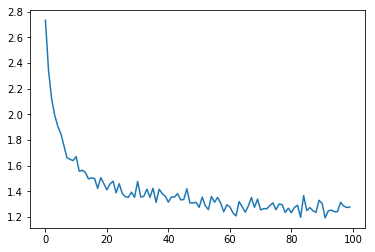

In [67]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses[1:])

In [60]:
def predict_max(model, X):
    hidden = model.initHidden()

    for i in range(X.size()[0]):
        y_score, hidden = model(X[i], hidden)
    
    return torch.max(y_score, 1)[1]


In [61]:
def calc_accuracy(model, num_samples=10000):
    num_corrects = 0
    for i in range(num_samples):
        category, line, category_tensor, line_tensor = randomTrainingExample()
        #print(line)
        y_pred = predict_max(model, line_tensor)
        #print(f'y_pred:{y_pred}, y:{category_tensor}')
        num_corrects += (category_tensor.item() == y_pred.item())
        
    return num_corrects/num_samples
        

In [62]:
calc_accuracy(rnn)

0.5914

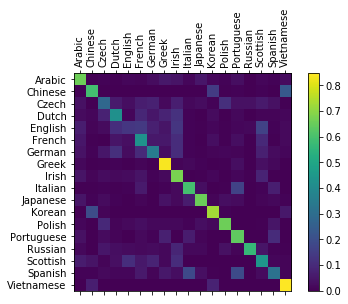

In [53]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.figure(figsize=(10,8))
plt.show()

In [54]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')


> Dovesky
(3.50) Russian
(2.29) Czech
(2.17) English

> Jackson
(3.15) Scottish
(2.26) Russian
(2.18) English

> Satoshi
(0.54) Japanese
(0.16) Italian
(0.09) Polish


In [55]:
predict('Fan')


> Fan
(3.50) Chinese
(3.30) Vietnamese
(2.39) Korean
